In [107]:
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame


start = datetime.datetime(2010, 1, 1)
end = datetime.datetime(2019, 8, 31)

df = web.DataReader("AAPL", 'yahoo', start, end)
df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-08-26,207.190002,205.059998,205.860001,206.490005,26043600.0,206.490005
2019-08-27,208.550003,203.529999,207.860001,204.160004,25873300.0,204.160004
2019-08-28,205.720001,203.320007,204.100006,205.529999,15938800.0,205.529999
2019-08-29,209.320007,206.660004,208.500000,209.009995,20990500.0,209.009995
2019-08-30,210.449997,207.199997,210.160004,208.740005,21143400.0,208.740005


In [108]:
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()

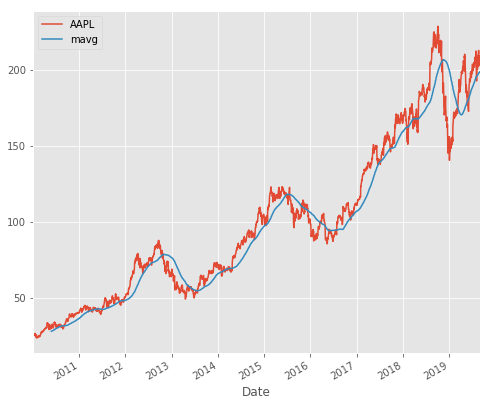

In [109]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style

# Adjusting the size of matplotlib
import matplotlib as mpl
mpl.rc('figure', figsize=(8, 7))
mpl.__version__

# Adjusting the style of matplotlib
style.use('ggplot')

close_px.plot(label='AAPL')
mavg.plot(label='mavg')
plt.legend()

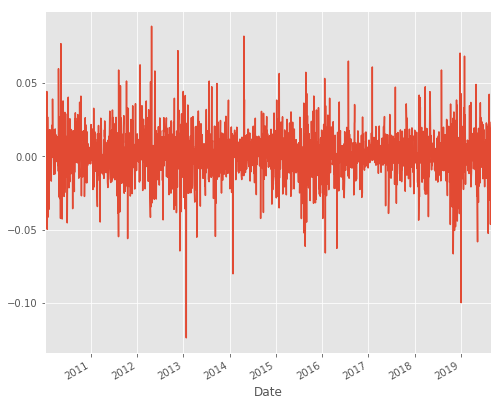

In [110]:
rets = close_px / close_px.shift(1) - 1
rets.plot(label='return')

In [111]:
dfcomp = web.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']

In [112]:
retscomp = dfcomp.pct_change()

corr = retscomp.corr()

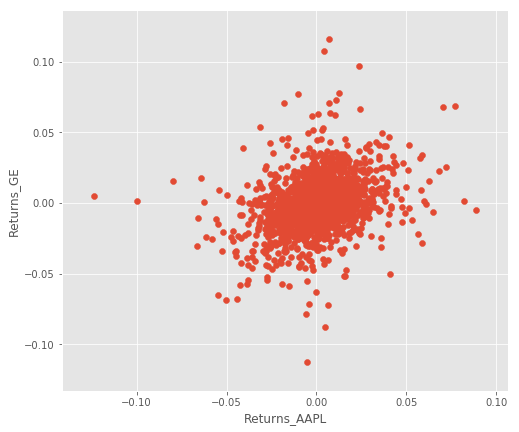

In [113]:
plt.scatter(retscomp.AAPL, retscomp.GE)
plt.xlabel("Returns_AAPL")
plt.ylabel("Returns_GE")

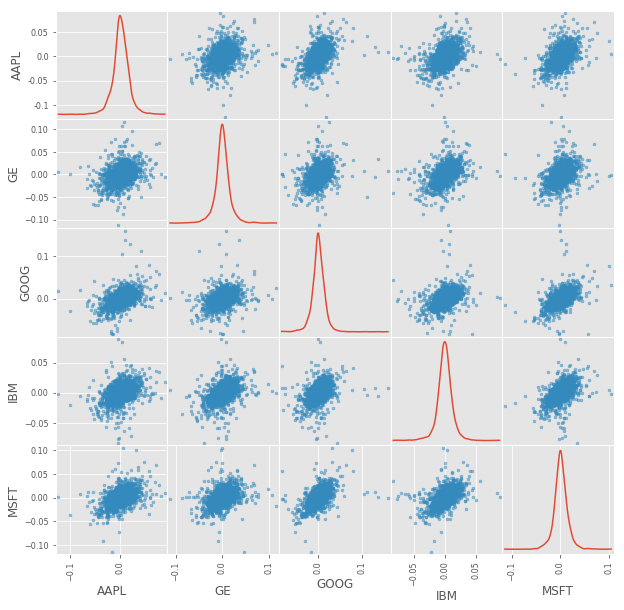

In [114]:
pd.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));


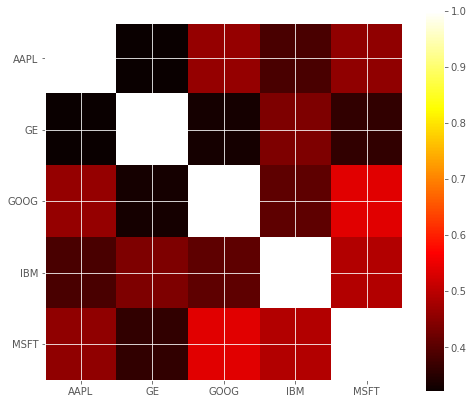

In [115]:
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);

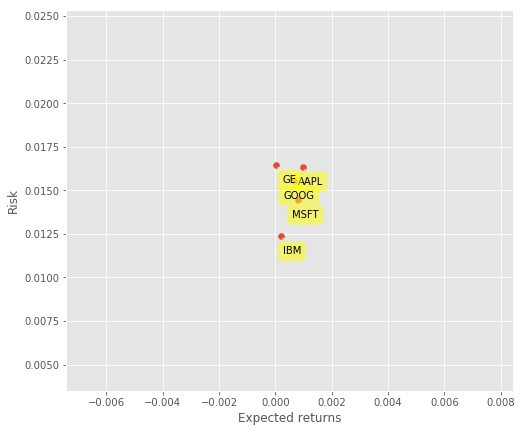

In [116]:
plt.scatter(retscomp.mean(), retscomp.std())
plt.xlabel('Expected returns')
plt.ylabel('Risk')
for label, x, y in zip(retscomp.columns, retscomp.mean(), retscomp.std()):
    plt.annotate(
        label, 
        xy = (x, y), xytext = (20, -20),
        textcoords = 'offset points', ha = 'right', va = 'bottom',
        bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.5),
        arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))

In [117]:
dfreg = df.loc[:,["Adj Close","Volume"]]
dfreg["HL_PCT"] = (df["High"] - df["Low"]) / df["Close"] * 100.0
dfreg["PCT_change"] = (df["Close"] - df["Open"]) / df["Open"] * 100.0

In [118]:
import math
import numpy as np
from sklearn import preprocessing
# Drop missing value
dfreg.fillna(value=-99999, inplace=True)
# We want to separate 1 percent of the data to forecast
forecast_out = int(math.ceil(0.01 * len(dfreg)))
# Separating the label here, we want to predict the AdjClose
forecast_col = 'Adj Close'
dfreg['label'] = dfreg[forecast_col].shift(-forecast_out)
X = np.array(dfreg.drop(['label'], 1))
# Scale the X so that everyone can have the same distribution for linear regression
X = preprocessing.scale(X)
# Finally We want to find Data Series of late X and early X (train) for model generation and evaluation
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
# Separate label and identify it as y
y = np.array(dfreg['label'])
y = y[:-forecast_out]


In [119]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [120]:
# Linear regression
clfreg = LinearRegression(n_jobs=-1)
clfreg.fit(X, y)
# Quadratic Regression 2
clfpoly2 = make_pipeline(PolynomialFeatures(2), Ridge())
clfpoly2.fit(X, y)

# Quadratic Regression 3
clfpoly3 = make_pipeline(PolynomialFeatures(3), Ridge())
clfpoly3.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('ridge', Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))])

In [121]:
# KNN Regression
clfknn = KNeighborsRegressor(n_neighbors=3)
clfknn.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=3, p=2,
          weights='uniform')

In [122]:
confidencereg = clfreg.score(X, y)
confidencepoly2 = clfpoly2.score(X, y)
confidencepoly3 = clfpoly3.score(X, y)
confidenceknn = clfknn.score(X, y)
# results
print('The linear regression confidence is ', confidencereg)
print('The quadratic regression 2 confidence is ', confidencepoly2)
print('The quadratic regression 3 confidence is ', confidencepoly3)
print('The knn regression confidence is ', confidenceknn)

The linear regression confidence is  0.967129293567
The quadratic regression 2 confidence is  0.968911975083
The quadratic regression 3 confidence is  0.971361801328
The knn regression confidence is  0.979883604603


In [125]:
forecast_set = clfknn.predict(X_lately)
dfreg['Forecast'] = np.nan
print(forecast_set)

[ 209.56981405  204.36005147  192.00984701  179.32147725  195.10597738
  172.11277771  184.57727559  170.96696472  190.38150533  206.01508077
  209.14449565  191.83034261  178.89909363  196.48121643  191.91978963
  215.7403005   201.33017985  217.15348816  201.7023112   168.82302348
  205.35243734  201.19228617  197.58846537  215.19373576  184.57869975]


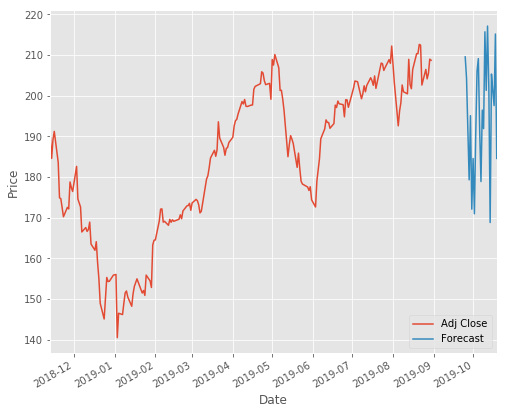

In [126]:
last_date = dfreg.iloc[-1].name
last_unix = last_date
next_unix = last_unix + datetime.timedelta(days=1)

for i in forecast_set:
    next_date = next_unix
    next_unix += datetime.timedelta(days=1)
    dfreg.loc[next_date] = [np.nan for _ in range(len(dfreg.columns)-1)]+[i]
dfreg['Adj Close'].tail(250).plot()
dfreg['Forecast'].tail(250).plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()